In [ ]:
from google.colab import drive

# Mount the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers torch pandas


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset
import os
import itertools
import json

# Load and preprocess the dataset
file_path = '/content/drive/Shared drives/DATA298B/Readmission/final_enhanced_patient_summaries.json'

# Load JSON data and convert to DataFrame
with open(file_path, 'r') as f:
    data = pd.DataFrame([json.loads(line) for line in f])

# Extract text data and labels
data['text'] = data['enhanced_summary']
data['label'] = data['readmission_status'].apply(lambda x: 1 if x == 'yes' else 0)

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-BigBird")

# Define a custom dataset class with contiguous tensors
class ReadmissionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: torch.tensor(val).contiguous() for key, val in encodings.items()}
        self.labels = torch.tensor(labels).contiguous()

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Define hyperparameters to tune
hyperparameters = {
    'num_train_epochs': [4],
    'per_device_train_batch_size': [16],
    'learning_rate': [3e-5],
}

# Create all combinations of hyperparameters
param_combinations = list(itertools.product(*hyperparameters.values()))

# Stratified cross-validation setup
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
metrics_per_combination = {}

# Folder to save the model
model_save_path = '/content/drive/Shared drives/DATA298B/Readmission/Dataset/saved_model17'
os.makedirs(model_save_path, exist_ok=True)

# Perform cross-validation with hyperparameter tuning
for param_idx, params in enumerate(param_combinations):
    print(f"\nTraining with hyperparameters: {params}")

    num_train_epochs, per_device_train_batch_size, learning_rate = params
    fold_metrics = []

    for fold, (train_index, test_index) in enumerate(skf.split(data, data['label'])):
        print(f"\nFold {fold + 1}/{k_folds}")

        # Split the data
        train_texts, test_texts = data['text'].iloc[train_index].tolist(), data['text'].iloc[test_index].tolist()
        train_labels, test_labels = data['label'].iloc[train_index].tolist(), data['label'].iloc[test_index].tolist()

        # Tokenize
        train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=4096)
        test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=4096)

        # Create dataset
        train_dataset = ReadmissionDataset(train_encodings, train_labels)
        test_dataset = ReadmissionDataset(test_encodings, test_labels)

        # Load the model
        model = AutoModelForSequenceClassification.from_pretrained("yikuan8/Clinical-BigBird", num_labels=2)

        # Set up training arguments
        training_args = TrainingArguments(
            output_dir=f'./results_fold_{fold}',
            num_train_epochs=num_train_epochs,
            per_device_train_batch_size=per_device_train_batch_size,
            per_device_eval_batch_size=16,
            learning_rate=learning_rate,
            evaluation_strategy="no",
            report_to="none",
        )

        # Define the Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )

        # Train the model
        trainer.train()

        # Save the model after training in each fold
        model.save_pretrained(os.path.join(model_save_path, f'model_fold_{fold + 1}_params_{param_idx}'))
        tokenizer.save_pretrained(os.path.join(model_save_path, f'model_fold_{fold + 1}_params_{param_idx}'))

        # Evaluate the model
        predictions = trainer.predict(test_dataset)
        pred_labels = predictions.predictions.argmax(-1)

        # Calculate metrics
        report = classification_report(test_labels, pred_labels, output_dict=True)
        fold_metrics.append(report)

    # Aggregate metrics for the hyperparameter configuration
    avg_metrics = {
        "precision": sum(d["weighted avg"]["precision"] for d in fold_metrics) / k_folds,
        "recall": sum(d["weighted avg"]["recall"] for d in fold_metrics) / k_folds,
        "f1-score": sum(d["weighted avg"]["f1-score"] for d in fold_metrics) / k_folds,
        "accuracy": sum(d["accuracy"] for d in fold_metrics) / k_folds,
    }

    metrics_per_combination[param_idx] = avg_metrics
    print(f"\nAverage Metrics for combination {param_idx}:")
    print(f"Precision: {avg_metrics['precision']:.4f}")
    print(f"Recall: {avg_metrics['recall']:.4f}")
    print(f"F1-score: {avg_metrics['f1-score']:.4f}")
    print(f"Accuracy: {avg_metrics['accuracy']:.4f}")

# Find the best hyperparameter combination
best_combination_idx = max(metrics_per_combination, key=lambda k: metrics_per_combination[k]['f1-score'])
best_metrics = metrics_per_combination[best_combination_idx]
print(f"\nBest hyperparameter combination: {param_combinations[best_combination_idx]}")
print(f"Best F1-score: {best_metrics['f1-score']:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Training with hyperparameters: (4, 16, 3e-05)

Fold 1/5


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-BigBird and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 336 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Step,Training Loss



Fold 2/5


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-BigBird and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 294 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Step,Training Loss



Fold 3/5


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-BigBird and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 336 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Step,Training Loss



Fold 4/5


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-BigBird and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 336 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Step,Training Loss



Fold 5/5


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-BigBird and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 336 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Step,Training Loss



Average Metrics for combination 0:
Precision: 0.9563
Recall: 0.9551
F1-score: 0.9550
Accuracy: 0.9551

Best hyperparameter combination: (4, 16, 3e-05)
Best F1-score: 0.9550


In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Specify the number of folds used during training
num_folds = 5
model_paths = [
    f'/content/drive/Shared drives/DATA298B/Readmission/Dataset/saved_model17/model_fold_{i+1}_params_0' for i in range(num_folds)
]

# Load the tokenizer from the Clinical-BigBird model
tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-BigBird")

# Example clinical notes for prediction
clinical_notes = [
    "The patient is a 65-year-old female with a history of congestive heart failure and chronic obstructive pulmonary disease (COPD). She was admitted for acute exacerbation of COPD, presenting with severe shortness of breath and low oxygen saturation. During her hospital stay, her condition required frequent adjustments to her oxygen therapy and multiple high-dose steroid treatments. The discharge plan included oxygen therapy at home and follow-up in one week. However, she lives alone and expressed concerns about managing her medications and oxygen setup. Her last lab results showed borderline low sodium and elevated blood urea nitrogen, with fluctuating blood pressure readings. She also had a recent hospitalization three weeks ago for a similar issue.",
    "The patient is a 45-year-old male with hypertension and Type 2 diabetes, who was admitted for routine monitoring after an elective orthopedic surgery. His hospital course was stable, with no complications, and he showed consistent improvement in mobility and pain control. Vital signs and lab results were within normal ranges at discharge. He was discharged with a home exercise plan and clear instructions on managing post-operative care, including regular check-ups with his primary physician. He has a strong support system at home, with family members who can assist with his care as needed. No significant health issues were noted at discharge.",
    "The patient is a 50-year-old male with schizophrenia and Type 2 diabetes, admitted for hyperglycemia and dehydration. He was stabilized with insulin and rehydration during his stay. However, he has a history of non-adherence to medication, which complicates his diabetes management. He is being discharged with insulin therapy and has been referred for mental health follow-up, but he has a limited support system. His lab results at discharge were within normal ranges, but his history of inconsistent medication adherence and frequent admissions suggests a high risk of readmission.",
    "The patient is a 55-year-old female with no significant prior medical history, admitted for knee replacement surgery. Her postoperative recovery was smooth, with no complications, and her vital signs remained stable throughout her stay. Physical therapy sessions showed good progress, and she was discharged with clear instructions for exercises and a follow-up with her orthopedic surgeon in two weeks. She has family support at home, and all necessary pain medications and supplies were arranged prior to discharge. Her final lab results were within normal limits, indicating a low risk of complications."
]

# Prepare inputs for the model
inputs = tokenizer(clinical_notes, truncation=True, max_length=4096, padding=True, return_tensors='pt')

# List to store predictions from each fold
all_predictions = []

# Make predictions using each model
for model_path in model_paths:
    # Load the saved model
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = logits.argmax(-1).numpy()  # Get the predicted class labels
        all_predictions.append(predictions)

# Convert list of predictions to a NumPy array
all_predictions = np.array(all_predictions)

# Average the predictions across all folds
average_predictions = np.mean(all_predictions, axis=0)

# Convert averaged predictions to class labels
final_predictions = ["Readmission" if pred >= 0.5 else "No Readmission" for pred in average_predictions]

# Display results
for note, label in zip(clinical_notes, final_predictions):
    print(f"Clinical Note: '{note}' => Predicted Label: '{label}'")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 145 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
Attention type 'block_sparse' is not possible if sequence_length: 145 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional 

Clinical Note: 'The patient is a 65-year-old female with a history of congestive heart failure and chronic obstructive pulmonary disease (COPD). She was admitted for acute exacerbation of COPD, presenting with severe shortness of breath and low oxygen saturation. During her hospital stay, her condition required frequent adjustments to her oxygen therapy and multiple high-dose steroid treatments. The discharge plan included oxygen therapy at home and follow-up in one week. However, she lives alone and expressed concerns about managing her medications and oxygen setup. Her last lab results showed borderline low sodium and elevated blood urea nitrogen, with fluctuating blood pressure readings. She also had a recent hospitalization three weeks ago for a similar issue.' => Predicted Label: 'Readmission'
Clinical Note: 'The patient is a 45-year-old male with hypertension and Type 2 diabetes, who was admitted for routine monitoring after an elective orthopedic surgery. His hospital course was

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-BigBird and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-0736fca6f895>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item

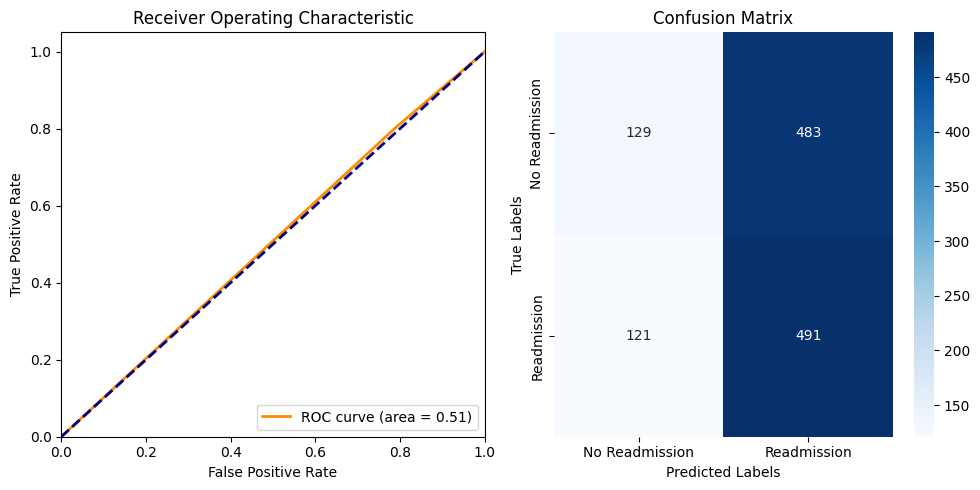

In [5]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset

# Load and preprocess the dataset
file_path = '/content/drive/Shared drives/DATA298B/Readmission/final_enhanced_patient_summaries.json'
data = pd.read_json(file_path, lines=True)

# Extract text data and labels
texts = data['enhanced_summary'].tolist()
labels = data['readmission_status'].apply(lambda x: 1 if x == 'yes' else 0).tolist()

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-BigBird")
model = AutoModelForSequenceClassification.from_pretrained("yikuan8/Clinical-BigBird")
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize the data
inputs = tokenizer(texts, padding=True, truncation=True, max_length=4096, return_tensors="pt")

# Custom dataset class
class ClinicalNotesDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# Prepare the DataLoader
dataset = ClinicalNotesDataset(inputs, labels)
loader = DataLoader(dataset, batch_size=16)  # Adjust batch size according to your system's capability

# Collect all predictions and actual labels
all_preds = []
all_labels = []

# Inference
with torch.no_grad():
    for batch in loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)[:, 1]  # Probability of class '1'
        predictions = torch.round(probabilities)  # Threshold probabilities to get binary predictions
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot the confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Readmission', 'Readmission'], yticklabels=['No Readmission', 'Readmission'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.show()
